# Milestone 2
This notebook summarizes all that we have done in the project so far, more detailed and thorough data exploration and cleaning can be found in each of the cleaning notebooks. Below are the research questions we wish to answer in this project.

1. How has the crops/livestock primary production developed since 1960?
2. Is there a connection between the development of livestock primary production and crop production?
3. How are the differences in production quantities between the different continents?
4. How has the development in agriculture affected emission of greenhouse gasses?

To answer this we are using 4 different datasets, all are collected from FAO-STAT (Food and Agriculture Organization of the United Nations - <http://www.fao.org/faostat/en/#data>). In this notebook we will describe and clean all of the data. 

**Note regarding our datasets from FAO:**  
- _There is limited geographical comparability due to differences between countries in methods and coverage, except for regions where countries are bound by regulations mandating harmonized methods, such as EU countries._
- _For shorter time periods, reasonably good comparability over time can be expected, as there is stability in the product definition and classification. However, as the time series are very long (from 1961) full comparability over time cannot be expected._

http://www.fao.org/faostat/en/#data/QL/metadata


## Contents
- Exploration and cleaning
    - [Livestock](#livestock)
    - [Crops](#crops)
    - [Population](#population)
    - [Emission](#emission)
- [Plan for Milestone 3](#plan)

### General Layout of Datasets
As we have collected all the datasets from the same source they are somewhat organized in the same way. There are 7 columns with metadata and for most of the values there are also flags that explain how the data was collected.


| Column name         | Explanation|
|------------------------|--------|
| Area                   |Name of country/area|
| Area Code              |Unique code for each country/area|
| Item                   |Type of product, e.g "Eggs, hen, in shell"|
| Item Code              |Unique code for each Item|
| Element                |Type data, e.g. Production, Yield, Milk Animals |
| Unit                   |The unit of the measurement of the element |
| Element Code           |Unique code based on pairs of Element and Unit|




|  Flag  | Meaning of flag        |
|--------|------------------------|
| *      | Unofficial data        |
| F      | FAO Estimate           |
| NaN    | Official data          |
| Fc     | Calculated data        |
| A      | Aggregate, may include official, semi-official, estimated or calculated data |
| M      | Data not available     | 
| Im     |FAO data based on imputation methodology |

In [36]:
# Import packages that are used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns; sns.set()
from matplotlib.font_manager import FontProperties
import warnings


---
<a id='livestock'></a>
## Livestock

The livestock dataset covers information on several livestock products globally, during the time 1961-2014. From 2014-2017 several values may be missing. The data contains all the production from both industrial production and farm production. The dataset is available at http://www.fao.org/faostat/en/#data/QL.   

Each row of the raw livestock dataset contains data on all years available, on a given metadata. There are 7 columns of metadata, which were described above, and the rest of the columns are data for each year. 

The Item also describes if a product is “indigenous” or not. If a product is not indigenous, the animal from which the product has been derived, has been imported.

In [37]:
livestock = pd.read_csv('raw_data/Production_LivestockPrimary_E_All_Data.csv', sep = ',', encoding = 'latin-1')
livestock.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y2013,Y2013F,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1000 Head,4000.0,F,4400.0,...,9500.0,F,9500.0,F,9337.0,Im,9369.0,Im,10688.0,F
1,2,Afghanistan,1062,"Eggs, hen, in shell",5410,Yield,100mg/An,25000.0,Fc,25000.0,...,18947.0,Fc,19474.0,Fc,21253.0,Fc,21263.0,Fc,18713.0,Fc


### Exploration

Thorough information on all columns can be found in the notebook *livestock_data_cleaning.ipynb*.   
Here are the different elements that are found in the dataset.


|  Element             | Description            |
|----------------------|------------------------|
| Laying               | Birds raised for laying eggs        |
| Yield                | How much of the animal which is used           |
| Production           | How much is produced          |
| Producing Animals/Slaughtered    | How many animals that are being produced for meat        |
| Yield/Carcass Weight | Same as yield, but also taking account size of animal |
| Milk Animals         | How many animals used for milk production     | 
| Prod Popultn         | Population of a given item  |


### Data Cleaning

**Elements**  
As we are primarily interested in meat production in this task, we take away all elements except _Production_ and _Producing Animals/Slaughtered_. 

In [38]:
livestock_prod = livestock[(livestock['Element'] == 'Production') | (livestock['Element'] == 'Producing Animals /Slaughtered') ]

**Items**  
After removing the other elements, we remove all items that are not meat.

In [39]:
livestock_meat = livestock_prod[livestock_prod['Item'].str.contains('Meat')]
livestock_meat.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y2013,Y2013F,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
8,2,Afghanistan,1137,"Meat indigenous, camel",5322,Production,Head,20000.0,F,22393.0,...,19500.0,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,3600.0,Fc,4031.0,...,3510.0,Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Units**  
To easily compare the data, we would like to have a joint unit for all the data. We see that for each item we get two numbers, number of animals (Heads) and the weight of produced meat (tonnes). We choose to only look at produced meat, and remove the head-counts.

In [40]:
livestock_meat = livestock_meat[livestock_meat['Unit'].str.contains('tonnes')]
livestock_meat.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y2013,Y2013F,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
10,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,3600.0,Fc,4031.0,...,3510.0,Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,2,Afghanistan,944,"Meat indigenous, cattle",5510,Production,tonnes,42984.0,Fc,45811.0,...,117829.0,Fc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Flags**  
The flags say something about the reliability of the data, but as this is the best data available we "trust" all the data. However, we do keep the flags in case we observe inconsistencies in the future.

**Reshaping**  
To have this dataset fit the same format as the others we have to reshape it, so that the yearly values are rows instead of columns. Afterwards we clean years to an int (remove Y before the year).

In [41]:
# Find the columns which are years, flags and metadata
col_years = [col for col in livestock_meat.columns if (col[0] == 'Y') and (col[-1] != 'F') ]
col_flags = [col for col in livestock_meat.columns if (col[0] == 'Y') and (col[-1] == 'F') ]
col_metadata = livestock_meat.columns[0:7]

# Do two melts, once on year and once on flag and add flags to dataframe with years
temp_years = livestock_meat.melt(id_vars = col_metadata, value_vars = col_years, var_name = 'Year', value_name = 'Value')
temp_flags = livestock_meat.melt(id_vars = col_metadata, value_vars = col_flags, var_name = 'FlagYear', value_name = 'Flag')
meat_data = temp_years.join(temp_flags['Flag'])

In [42]:
# Remove Y in years
meat_data['Year'] = meat_data['Year'].str.replace('Y', '').astype(int)

In [43]:
meat_data.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Year,Value,Flag
0,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,1961,3600.0,Fc
1,2,Afghanistan,944,"Meat indigenous, cattle",5510,Production,tonnes,1961,42984.0,Fc


**Missing Data**  
Below we can see that there is some data missing in the dataset, and when we are talking about production at country-level this is not very suprising. Since 1960, a lot of states have been founded and dissolved, with the Soviet Union in 1991 as the most notable. We assume that the missing year is included somewhere else (for example Albania in Soviet Union), and remove all rows (that is years) with missing values.  

Also, we choose to remove the data after 2013 as a lot of information is missing here and we wish to have consistent data.

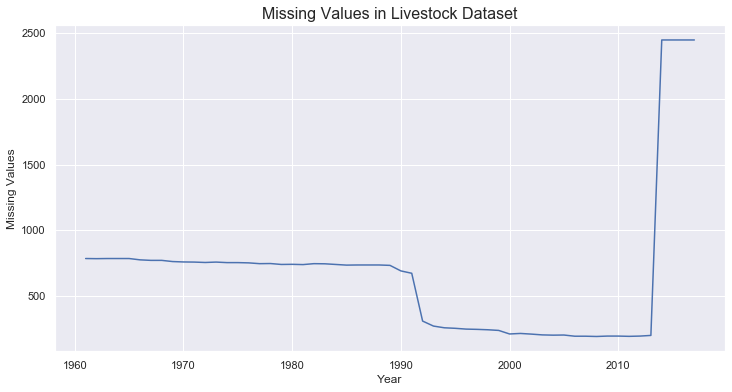

In [44]:
# Create series with missing values
missing_values = meat_data['Value'].isnull().groupby(meat_data['Year']).sum()

# Plot missing values with years on x-axis and missing values on y-axis
f = plt.figure(figsize = (12,6))
plt.plot(missing_values.index, missing_values.values)
plt.title('Missing Values in Livestock Dataset', fontsize = 16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Missing Values', fontsize=12)
plt.show()

In [45]:
# Remove all null values
meat_data = meat_data[meat_data['Value'].notnull()]

# Also remove all data after 2014 to have consistent data
meat_data = meat_data[meat_data['Year'] < 2014]

**Categorizing the Data**  
We would like to divide our dataset into areas, countries and continents for easier use in the future. Luckily, because of the way area codes are organized, this is easily done. Everything under 251 is countries, and everything above 5000 are areas. 

In [46]:
from scripts.helpers import split_fao_data
print(split_fao_data.__doc__)

meat_countries, meat_area, meat_continents = split_fao_data(meat_data)


    Function that splits data into countries, areas and continents.
    params:
        df: fao-dataframe that includes area codes.
        
    returns:
        countries: dataframe with area-code < 500
        area: dataframe with only area-code > 500
        continents: dataframe with the 6 continents
    
    


#### Summary of Livestock Dataset
After the data cleaning we have three dataframes, one for countries, one for area and one with only continents. 
We have kept the cleaning quite general in order to not miss important information, but have still ended up with a dataset that is easy to use.

### First look at the clean Livestock data
We ended up with 3 separate files for the livestock production data. One data set for the production aggregated continentally, one for country specific production and one for more specific areas within continents (e.g. Western Africa, Northern Europe). Let's take a look at how the production quantities have changed and what meats we have.

In [47]:
meat_area = pd.read_pickle('data/pickles/meat_area.pkl')
meat_cont = pd.read_pickle('data/pickles/meat_continents.pkl')
meat_country = pd.read_pickle('data/pickles/meat_countries.pkl')
meat_cont.head(3)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Year,Value,Flag
0,5100,Africa,1122,"Meat indigenous, ass",5510,Production,tonnes,1961,4150.0,A
1,5100,Africa,1084,"Meat indigenous, bird nes",5510,Production,tonnes,1961,5400.0,A
2,5100,Africa,972,"Meat indigenous, buffalo",5510,Production,tonnes,1961,NaN,A


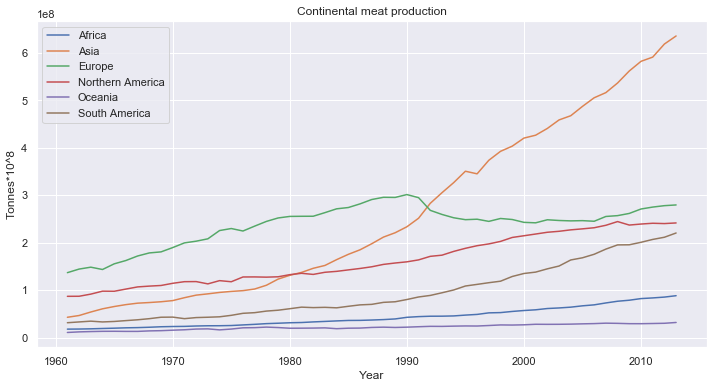

In [48]:
yearly_meat = meat_cont.groupby(['Area', 'Year']).agg({'Value':'sum'}).reset_index()

fig = plt.figure(figsize=(12, 6))
for cont in yearly_meat.Area.unique():
    y = yearly_meat[yearly_meat['Area'] == cont].Value.values
    x = yearly_meat[yearly_meat['Area'] == cont].Year.values
    
    plt.plot(x, y, label = cont)
    plt.title('Continental meat production')
    plt.ylabel('Tonnes*10^8')
    plt.xlabel('Year')
    plt.legend()

We can see that meat production has increased globally, and Asia has been the major driver in this increase. The data here is not normalized to population and Asia has experienced a major increase in population so lets take a look at production normalized to population. 

In [49]:
population = pd.read_csv('./data/csv/pop_continents.csv')

In [50]:
def plot_yearly(yearly_item, item, yearly_population, by = 'Area'):
    warnings.filterwarnings('ignore')
    fig, axs = plt.subplots(2, 2)
    
    yearly_population.sort_values(by = 'Year', inplace = True)
    groups = yearly_item[by].unique()
    world_year_population = yearly_population.groupby('Year').agg({'Value':'sum'}).reset_index()
    
    mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:pink']  
    fig.set_size_inches(15,12)

    plot_y = []
    for group in groups:
        y = yearly_item[yearly_item[by] == group].Value.values
        x = yearly_item[yearly_item[by] == group].Year.values
        
        axs[0,0].plot(x, y)
        
        if by == 'Area':
            y_n = yearly_item[yearly_item[by] == group].Value.values/(yearly_population[yearly_population[by] == group].Value.values*1000)
            axs[1,0].plot(x, y_n)

        plot_y.append(yearly_item[yearly_item[by] == cont].Value.values.tolist())

    axs[0,0].legend(groups)
    axs[0,0].set_title(item + ' production per continent')
    axs[0,0].set_xlabel('Year')
    axs[0,0].set_ylabel('Tonnes')
    axs[0,0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0}')) 

    axs[0,1].stackplot(x, np.vstack(plot_y), labels = groups, alpha=0.8)
    axs[0,1].legend(loc='upper left')
    axs[0,1].set_title('Total world '+ item +' production')
    axs[0,1].set_xlabel('Year')
    axs[0,1].set_ylabel('Tonnes')
    axs[0,1].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0}'))
    
    if by == 'Area':
        
        axs[1,0].set_title(item + ' production per continent, normalized on continent population')
        axs[1,0].set_xlabel('Year')
        axs[1,0].set_ylabel('Tonnes')

        total_year_item = yearly_item.groupby('Year').agg({'Value':'sum'}).reset_index()

        axs[1,1].plot(total_year_item['Year'].values,
                total_year_item['Value'].values/(world_year_population['Value'].values*1000))
        axs[1,1].legend(['Total all continents'])
        axs[1,1].set_title('Total, normalized on population')
        axs[1,1].set_xlabel('Year')
        axs[1,1].set_ylabel('Tonnes')

    plt.show()

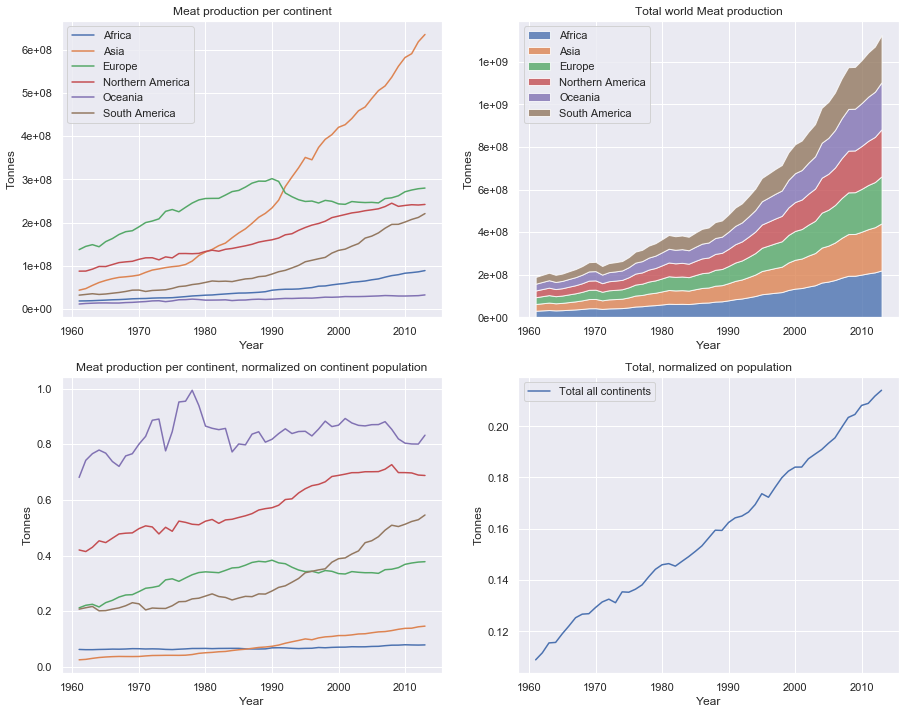

In [51]:
area_year_population = population.groupby(['Area', 'Year']).agg({'Value':'sum','Unit':'first'}).reset_index()
plot_yearly(yearly_meat, 'Meat', area_year_population, 'Area')

When we normalize by population count, we can see that Oceania is fairly volatile, perhaps a result of low population compared to the meat production. Overall we can see that when the production is normalized by population, Asia is not nearly as significant. In fact, Oceania has the largest production of meat per person. However, we can see an increase in production for all continents except Europe, where the production has not risen since the 90s. In the end, total meat production per year per person has more than doubled in the last 50 years.

Let us take a look into the production of different meats. We will choose to only focus on indigenous meat production for the time being.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


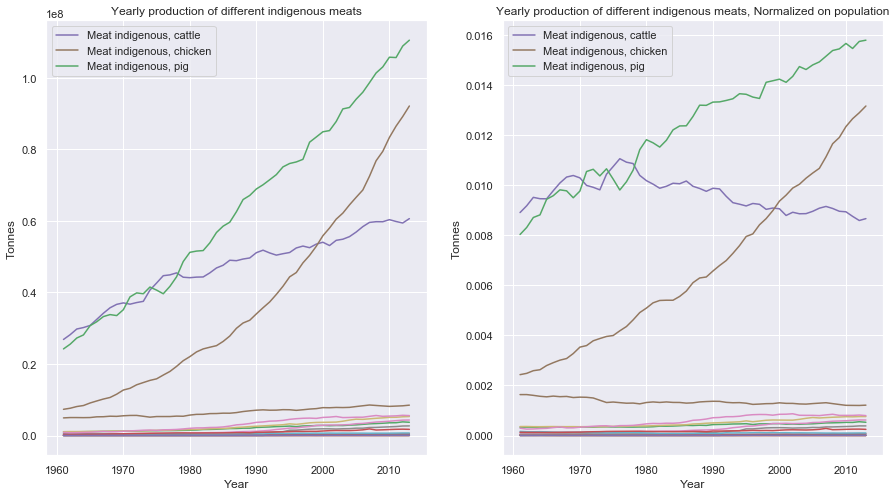

In [52]:
warnings.filterwarnings('ignore')
#Drop everythin except indigenous and drop some aggregates
meat_cont_ind = meat_cont[(meat_cont.Item.str.contains('indigenous')) &
                          (np.logical_not(meat_cont.Item.str.contains('total'))) &
                          (np.logical_not(meat_cont.Item.str.contains('poultry')))]

meat_cont_ind = meat_cont_ind.groupby(['Item', 'Year']).agg({'Value':'sum'}).reset_index()
fig = plt.figure(figsize = (15,8))

largest_groups = meat_cont_ind[meat_cont_ind['Year'] == 2013].sort_values(by = 'Value', ascending = False).head(3).Item

wy_population = area_year_population.groupby('Year').agg({'Value':'sum'}).reset_index()
groups = meat_cont_ind.Item.unique()
labels = meat_cont_ind[meat_cont_ind['Year'] == 2013].sort_values(by = 'Value', ascending = False).iloc[1:6, :].Item.values 

for group in groups:
    y = meat_cont_ind[meat_cont_ind['Item'] == group].Value.values
    x = meat_cont_ind[meat_cont_ind['Item'] == group].Year.values
        
    plt.subplot(1,2,1)
    if group in list(largest_groups):
        plt.plot(x, y, label = group)
    else:
        plt.plot(x, y)
        
    plt.xlabel('Year')
    plt.ylabel('Tonnes')
    plt.title('Yearly production of different indigenous meats')
    plt.legend()
    
    
    plt.subplot(1,2,2)
    y = meat_cont_ind[meat_cont_ind['Item'] == group].Value.values/(wy_population.Value.values*1000)
    if group in list(largest_groups):
        plt.plot(x, y, label = group)
    else:
        plt.plot(x, y)
    
    plt.xlabel('Year')
    plt.ylabel('Tonnes')
    plt.title('Yearly production of different indigenous meats, Normalized on population')
    plt.plot(x, y)

We clearly have 3 different meats with a significantly higher production quantity than the others. Overall the production quantities seem to have increased yearly in total, but when normalized by population count we can see that some meats have decreased in production.

In [18]:
meat_cont_ind[meat_cont_ind['Year'] == 2013].sort_values(by = 'Value', ascending = False).head()

,Item,Year,Value
688,"Meat indigenous, pig",2013,110530398.0
317,"Meat indigenous, chicken",2013,92132530.0
264,"Meat indigenous, cattle",2013,60646471.0
847,"Meat indigenous, sheep",2013,8497179.0
900,"Meat indigenous, turkey",2013,5579889.0


Our 3 most commonly produced meats are (not surprisingly) pig, chicken and cattle.

***
<a id='crops'></a>
## Crops

The crops dataset covers production of all primary crops for all countries and regions in the world and **the production is only for human consumption**. Household production is not included in the data, that is, crops that are planted for personal consumption, in for example one’s garden. The dataset is available at https://www.kaggle.com/unitednations/global-food-agriculture-statistics.  

Each row of the crops dataset contains data for a certain country/area, crop item and year. There are 7 columns of metadata, and the years in the dataset span from 1961 to 2007.

In [19]:
data = pd.read_csv('raw_data/fao_data_crops_data.csv.zip', compression='zip', header=0, sep=',', quotechar='"')
data.head(3)

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Americas +,31,Area Harvested,2007.0,Ha,49404.0,A,agave_fibres_nes
1,Americas +,31,Area Harvested,2006.0,Ha,49404.0,A,agave_fibres_nes
2,Americas +,31,Area Harvested,2005.0,Ha,49404.0,A,agave_fibres_nes


### Explanation of Columns


#### Elements
- **Area harvested** refer to the area under cultivation. Area under cultivation means the area that corresponds to the total sown area, but after the harvest it excludes ruined areas (e.g. due to natural disasters). If the same land parcel is used twice in the same year, the area of this parcel can be counted twice. 
- **Production quantity** means the harvested production. Harvested production means production including on-holding losses and wastage, quantities consumed directly on the farm and marketed quantities, indicated in units of basic product weight. *Harvest year* means the calendar year in which the harvest begins. 
- **Yield** means the harvested production per ha for the area under cultivation. 
- **Seed** quantity comprises all amounts of the commodity in question used during the reference period for reproductive purposes, such as seed or seedlings. Usually, the average seed rate in any given country does not vary greatly from year to year.
- **Gross Production, Net Production, Net per capita PIN, Grs per capita PIN, Net PIN, Gross PIN** (element codes > 140)

#### Categories
Crop statistics are recorded for 172 products, covering the following categories: Fibre Crops Primary, Cereals, Coarse Grain, Citrus Fruit, Fruit, Jute Jute-like Fibres, Oilcakes Equivalent, Oil crops Primary, Pulses, Roots and Tubers, Treenuts and Vegetables and Melons. The objective is to comprehensively cover production of all primary crops for all countries and regions in the world. 



### Data Cleaning

#### Renaming
First of all we rename the columns to fit the livestock dataset.  
This is mainly to make the first letter capital, but _Footnote_ changes to _Flag_ and _Category_ changes to _Item_.

In [20]:
new_names = {'country_or_area': 'Area', 'element_code': 'Element Code', 
             'element': 'Element', 'year': 'Year', 'unit': 'Unit', 
             'value': 'Value', 'value_footnotes': 'Flag', 'category': 'Item'}

data.rename(columns = new_names, inplace = True)
data.head(2)

,Area,Element Code,Element,Year,Unit,Value,Flag,Item
0,Americas +,31,Area Harvested,2007.0,Ha,49404.0,A,agave_fibres_nes
1,Americas +,31,Area Harvested,2006.0,Ha,49404.0,A,agave_fibres_nes


#### Unnecessary rows:
The dataset is ordered according to the alphabetical order of the _Item_ and after the end of each Item, there are rows that contain the footnote-descriptions mentioned before.  
We therefore need to remove these rows since they don't contain any useful data.

In [21]:
# Removing rows that do not contain useful information
keep_col = np.logical_not(data.Area.isin(['fnSeqID', 'Fc', 'A ', 'NR', 'F ', '* ']))
crops_data = data[keep_col]

#### Keep only category totals

Since we want to analyse the general production of crops it is more interesting for us to look at the total production of the different categories instead of looking at every type of item. We will therefore only keep the totals in our dataset. The categories are stored using the following item names:
- Fibre Crops Primary = fibre_crops_primary 
- Cereals = cereals_total
- Coarse Grain = coarse_grain_total
- Citrus Fruit = citrus_fruit_total
- Fruit = fruit_excl_melons_total
- Jute Jute-like Fibres = jute_jute_like_fibres
- Oilcakes Equivalent = oilcakes_equivalent
- Oil crops Primary = oil_crops_primary
- Pulses = pulses_total
- Roots and Tubers = roots_and_tubers_total 
- Treenuts = treenuts_total 
- Vegetables and Melons = vegetables_melons_total

In [22]:
keywords = ['_total', 'primary', 'jute_jute', 'oilcakes']
items = crops_data.Item
crops_categorized = crops_data[items.str.contains('|'.join(keywords))]

print("Item categories in categorized dataset:\n", crops_categorized.Item.unique())

Item categories in categorized dataset:
 ['cereals_total' 'citrus_fruit_total' 'coarse_grain_total'
 'fibre_crops_primary' 'fruit_excl_melons_total' 'jute_jute_like_fibres'
 'oilcakes_equivalent' 'oilcrops_primary' 'pulses_total'
 'roots_and_tubers_total' 'treenuts_total' 'vegetables_melons_total']


#### Missing Data

Below we check if there is missing data in our dataset, and as we see there is none.

In [23]:
print("Missing information in categorized dataset: \n", crops_categorized.isna().sum())

Missing information in categorized dataset: 
 Area            0
Element Code    0
Element         0
Year            0
Unit            0
Value           0
Flag            0
Item            0
dtype: int64


#### Elements

**Observation:** Are the elements apart form Production Quantity really necessary?

- *Seed* is the amount of seeds that were planted, which is not relevant for the scope of this project.
- *Area Harvested* is the amount of land that was used for planting the crops in our dataset, which is not relevant for the scope of this project.
- *Yield* is the amount of crops that was given by the planted area, which is not relevant for the scope of this project.

We will therefore remove element categories: Seed, Area Harvested and Yield.

In [24]:
elements = ['Seed', 'Area Harvested', 'Yield']
crops_processed = crops_categorized[np.logical_not(crops_categorized['Element'].isin(elements))]
crops_processed.head(3)

,Area,Element Code,Element,Year,Unit,Value,Flag,Item
364540,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2007.0,1000 Int. $,896908.0,A,cereals_total
364541,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2006.0,1000 Int. $,718798.0,A,cereals_total
364542,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2005.0,1000 Int. $,841895.0,A,cereals_total


But what do the element categories with element codes > 140 include? Can we remove these?

#### Element codes > 140

In [25]:
elem_codes = ['152', '154', '434', '438', '432', '436']
study_data = crops_processed[crops_processed['Element Code'].isin(elem_codes)]
print("Number of countries in this data: ", study_data.Area.unique().shape[0])
study_data.head(5)

Number of countries in this data:  222


,Area,Element Code,Element,Year,Unit,Value,Flag,Item
364540,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2007.0,1000 Int. $,896908.0,A,cereals_total
364541,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2006.0,1000 Int. $,718798.0,A,cereals_total
364542,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2005.0,1000 Int. $,841895.0,A,cereals_total
364543,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2004.0,1000 Int. $,549037.0,A,cereals_total
364544,Afghanistan,152,Gross Production 1999-2001 (1000 I$),2003.0,1000 Int. $,685931.0,A,cereals_total


From what we can see in the new dataset that only contain these elements, both the rows in the beginning and end have the Item cereals_total. Is this the only Item?

In [26]:
study_data.Item.unique()

array(['cereals_total'], dtype=object)

Apparently so. Does this catgory exist for the other type of elements as well? Because if it does, we should be able to remove the elements with codes 152-438 from our dataset.

In [27]:
study_data_2 = crops_processed[crops_processed.Item.str.contains('cereals_total')]
study_data_2 = study_data_2[np.logical_not(study_data_2['Element Code'].isin(elem_codes))]
print("Number of countries in this data: ", study_data_2.Area.unique().shape[0])
study_data_2['Element Code'].unique()

Number of countries in this data:  225


array(['51'], dtype=object)

We can now see that the data for the Item 'cereals_total' with element codes > 140 are subgroups of element codes < 140. We can therefore remove this data from our dataset.

In [28]:
# Drop rows with element codes > 140
drop_col = np.logical_not(crops_processed['Element Code'].isin(elem_codes))
crops_cleaned = crops_processed[drop_col]
crops_cleaned.head(3)

,Area,Element Code,Element,Year,Unit,Value,Flag,Item
364916,Afghanistan,51,Production Quantity,2007.0,tonnes,5778000.0,A,cereals_total
364917,Afghanistan,51,Production Quantity,2006.0,tonnes,4638000.0,A,cereals_total
364918,Afghanistan,51,Production Quantity,2005.0,tonnes,5425000.0,A,cereals_total


#### Area names with '+'

There are countries/areas that contain a '+' at the end of the name. What names contain this sign and what do they have in common?

In [29]:
# Examining what names contain '?'
country_series = crops_cleaned.Area
names_with_sign = country_series[country_series.str.endswith('+')]
names_with_sign.unique()

array(['Africa +', 'Americas +', 'Asia +', 'Australia and New Zealand +',
       'Caribbean +', 'Central America +', 'Central Asia +',
       'Eastern Africa +', 'Eastern Asia +', 'Eastern Europe +',
       'Europe +', 'European Union +',
       'LandLocked developing countries +', 'Least Developed Countries +',
       'Low Income Food Deficit Countries +', 'Melanesia +',
       'Micronesia +', 'Middle Africa +',
       'Net Food Importing Developing Countries +', 'Northern Africa +',
       'Northern America +', 'Northern Europe +', 'Oceania +',
       'Small Island Developing States +', 'South America +',
       'South-Eastern Asia +', 'Southern Africa +', 'Southern Asia +',
       'Southern Europe +', 'Western Africa +', 'Western Asia +',
       'Western Europe +', 'World +', 'Polynesia +'], dtype=object)

All of the country/area names that contain a '+' at the end are all areas. We can therefore divide the dataset into several groups: one with all countries, one with all continents and one with the remaining areas.

#### Categorizing the Data 

In [30]:
# Splitting crops_data into country, continent and area based sets and renaming Area column
crops_country = crops_cleaned[np.logical_not(country_series.str.endswith('+'))].rename({'Area': 'Area'}, axis=1)
crops_remain = crops_cleaned[country_series.str.endswith('+')]

# Remove last two characters from continent/area name
crops_remain.Area = crops_remain.Area.str[:-2]

continents = ['Africa', 'Northern America', 'South America', 'Asia', 'Oceania', 'Europe']
is_continent = crops_remain.Area.isin(continents)

crops_continent = crops_remain[is_continent].rename({'Area': 'Area'}, axis=1)
crops_area = crops_remain[np.logical_not(is_continent)].rename({'Area': 'Area'}, axis=1)

print('Number of unique countries:', crops_country.Area.unique().shape[0])
print('Number of unique continents:', crops_continent.Area.unique().shape[0])
print('Number of unique areas:', crops_area.Area.unique().shape[0])

Number of unique countries: 219
Number of unique continents: 6
Number of unique areas: 28


### First look at the clean crops data
Similarly to the Livestock data we ended up with 3 separate files for the crops data. One data set for the production aggregated continentally, one for country specific production and one for more specific areas within continents (e.g. Western Africa, Northern Europe). Let's take a look at how the production quantities have changed and what meats we have.

In [31]:
crops_area = pd.read_pickle('data/pickles/crops_areas.pkl')
crops_cont = pd.read_pickle('data/pickles/crops_continents.pkl')
crops_country = pd.read_pickle('data/pickles/crops_countries.pkl')

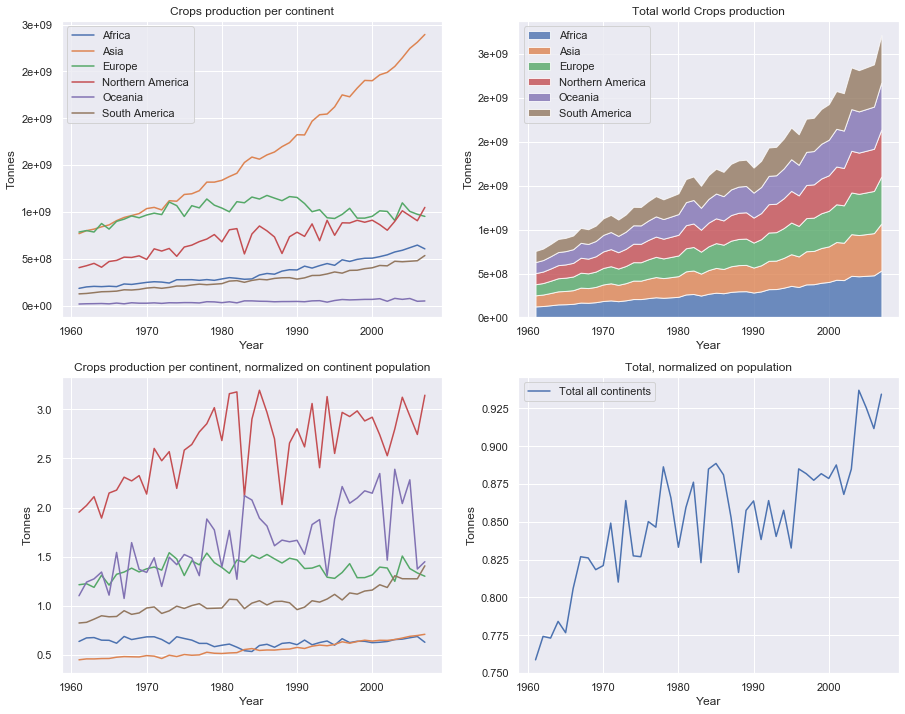

In [32]:
crops_yearly = crops_cont.groupby(['Area', 'Year']).agg({'Value':'sum'}).reset_index()
plot_yearly(crops_yearly, 'Crops', area_year_population, 'Area')

We can see a great increase in crops production in Asia and a slight increase in the other continents except Europe. The data seems to be extremely volatile for North America and Oceania.
However, overall we can see a production increase in all continents. Further investigation into reasons for the high volatility will be needed. The total crop production per person has seen a significant increase in the last 50 years.

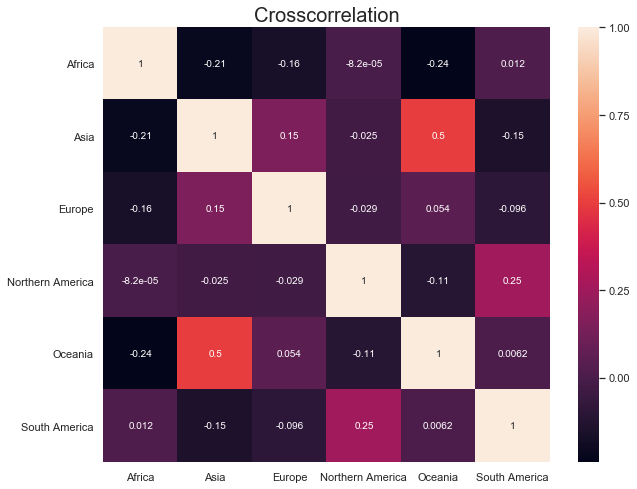

In [33]:
crops_cont_y = pd.DataFrame(crops_yearly[crops_yearly['Area'] == 'Africa'].Year)

for continent in crops_yearly['Area'].unique():
    crops_cont_y[continent] = crops_yearly[crops_yearly['Area'] == continent].Value.values

corr = np.log(crops_cont_y.iloc[:, 1:10]).diff().corr()
fig = plt.figure(figsize = (10, 8))

ax = sns.heatmap(corr, annot = True, vmax = 1)
plt.yticks(rotation= 0)
plt.xticks(rotation= 0)
plt.title('Crosscorrelation', fontsize = 20)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

The change in production quantities year on year shows no correlation between different continents except between Asia and Oceania.

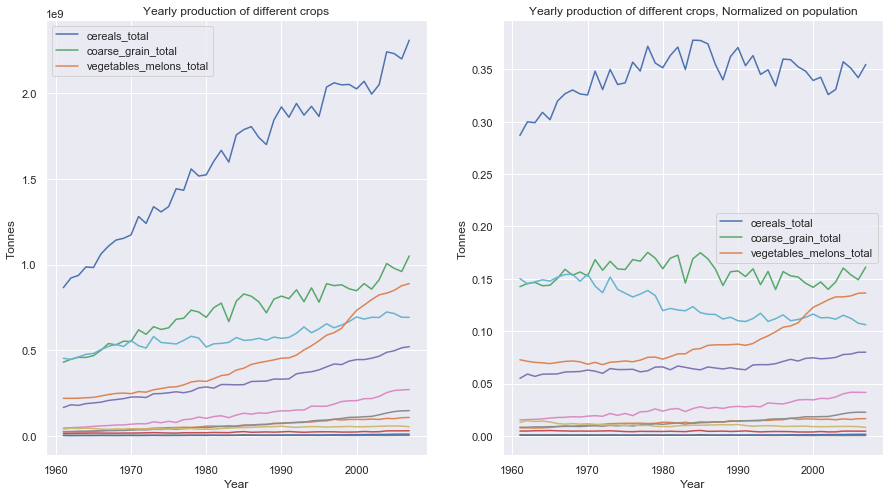

In [34]:
crops_items_yearly = crops_cont.groupby(['Item', 'Year']).agg({'Value':'sum'}).reset_index()
fig = plt.figure(figsize = (15,8))

wy_population = area_year_population.groupby('Year').agg({'Value':'sum'}).reset_index()
groups = crops_items_yearly.Item.unique()
largest_groups = crops_items_yearly[crops_items_yearly['Year'] == 2007].sort_values(by = 'Value', ascending = False).head(3).Item

for group in groups:
    y = crops_items_yearly[crops_items_yearly['Item'] == group].Value.values
    x = crops_items_yearly[crops_items_yearly['Item'] == group].Year.values

    plt.subplot(1,2,1)
    
    if group in list(largest_groups):
        plt.plot(x, y, label = group)
    else:
        plt.plot(x, y)

    plt.xlabel('Year')
    plt.ylabel('Tonnes')
    plt.title('Yearly production of different crops')
    plt.legend()

    
    plt.subplot(1,2,2)
    y = crops_items_yearly[crops_items_yearly['Item'] == group].Value.values/(wy_population.Value.values*1000)
    plt.xlabel('Year')
    plt.ylabel('Tonnes')
    plt.title('Yearly production of different crops, Normalized on population')
    
    if group in list(largest_groups):
        plt.plot(x, y, label = group)
    else:
        plt.plot(x, y)

    plt.legend()

In [66]:
crops_items_yearly[crops_items_yearly['Year'] == 2007].sort_values(by = 'Value', ascending = False).head()

,Item,Year,Value
46,cereals_total,2007.0,2.310504e+09
140,coarse_grain_total,2007.0,1.050823e+09
563,vegetables_melons_total,2007.0,8.893487e+08
469,roots_and_tubers_total,2007.0,6.920577e+08
234,fruit_excl_melons_total,2007.0,5.212259e+08


The plots show that the crop group cereals is produced in significantly higher quantities than any other group. 

***
<a id='population'></a>
## Population Data

In order to interpret our data in a sensible way we also need population-data, as it of course will be a difference in food production with current population compared to 1960. The data is also collected from FAO, and looks very similar to the Livestock-dataset. The dataset can be found here http://www.fao.org/faostat/en/#data/OA.

In [36]:
population = pd.read_csv('./raw_data/fao_data_population.csv')
population.head(3)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1950,1950,1000 persons,7752.118,X,International reliable sources,"UNDESA, Population Division – World Population..."
1,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1951,1951,1000 persons,7840.156,X,International reliable sources,NaN
2,OA,Annual population,2,Afghanistan,511,Total Population - Both sexes,3010,Population - Est. & Proj.,1952,1952,1000 persons,7935.997,X,International reliable sources,NaN


In [37]:
# Check unique values in dataset
for (col_name, col_data) in population.iteritems():
    print('{} has {} unique values.'.format(col_name, pd.unique(col_data).shape[0]))

Domain Code has 1 unique values.
Domain has 1 unique values.
Area Code has 273 unique values.
Area has 273 unique values.
Element Code has 1 unique values.
Element has 1 unique values.
Item Code has 1 unique values.
Item has 1 unique values.
Year Code has 69 unique values.
Year has 69 unique values.
Unit has 1 unique values.
Value has 16730 unique values.
Flag has 2 unique values.
Flag Description has 2 unique values.
Note has 2 unique values.


We see that many of the columns are irrelevant as they contain the same information in all columns. This is Domain Code, Domain, Element, Element Code, Item Code, Item, Year Code (Same as Year) and Note.  
We actually have two Flags: A and X. X is regarded most reliable(_International reliable sources_), but we will also regard A (_Aggregate, may include official, semi-official, estimated or calculated data_) as reliable. Therefore we also remove these columns.

In [38]:
drop_col = ['Domain Code', 'Domain', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code', 'Flag', 'Flag Description', 'Note']
population.drop(drop_col, axis = 1, inplace = True)
population.head(3)

,Area Code,Area,Year,Unit,Value
0,2,Afghanistan,1950,1000 persons,7752.118
1,2,Afghanistan,1951,1000 persons,7840.156
2,2,Afghanistan,1952,1000 persons,7935.997


As we only have data in the other datasets from 1961 to 2007/2013, we remove the extra years. 

In [39]:
population = population[(population['Year'] > 1960) & (population['Year'] < 2014)]

**Categorizing the Data**  
We would like to divide our dataset into areas, countries and continents for easier use in the future. Luckily, because of the way area codes are organized, this is easily done. Everything under 251 is countries, and everything above 5000 are areas. 

In [40]:
from scripts.helpers import split_fao_data
print(split_fao_data.__doc__)

pop_countries, pop_area, pop_continents = split_fao_data(population)


    Function that splits data into countries, areas and continents.
    params:
        df: fao-dataframe that includes area codes.
        
    returns:
        countries: dataframe with area-code < 500
        area: dataframe with only area-code > 500
        continents: dataframe with the 6 continents
    
    


#### First look at the data
To check if the data seems reasonable we plot the development in population for each continent.

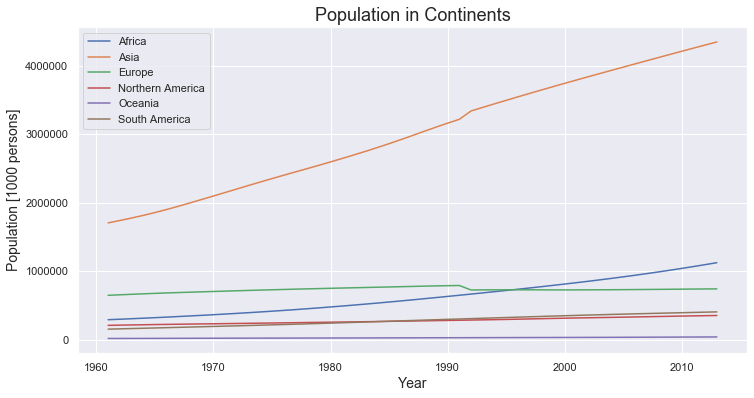

In [41]:
tmp = pop_continents.groupby(['Year', 'Area']).agg({'Value':'sum'}).reset_index()

f = plt.figure(figsize=(12, 6))

for area in tmp.Area.unique():
    y = tmp[tmp['Area'] == area].Value.values
    x = tmp[tmp['Area'] == area].Year.values
    plt.plot(x,y)
    
plt.legend(tmp.Area.unique())
plt.title('Population in Continents', fontsize = 18)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Population [1000 persons]', fontsize = 14)
plt.show()

The data looks reasonable at first glance, but we see that there is some wierd behaviour in Asia and Europe around 1990. To examine this we plot each of the continents seperately.

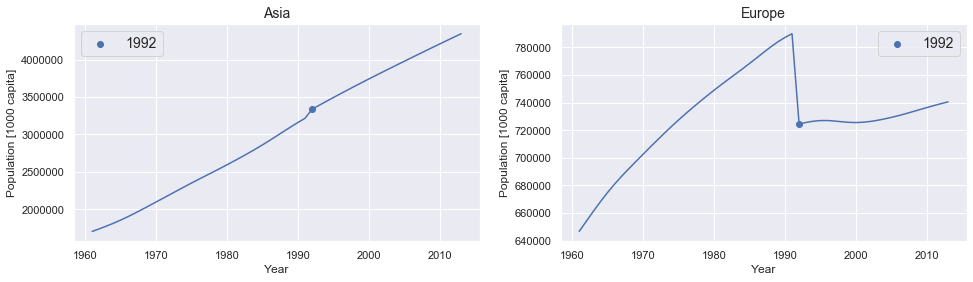

In [42]:
pop_europe_asia = pop_continents[(pop_continents['Area'] == 'Europe') | (pop_continents['Area'] == 'Asia')]
tmp = pop_europe_asia.groupby(['Year', 'Area']).agg({'Value':'sum'}).reset_index()

f = plt.figure(figsize=(16, 4))

for (ind, area) in zip(range(1,1 + tmp.Area.unique().shape[0]), tmp.Area.unique()):
    plt.subplot(1, 2, ind)
    y = tmp[tmp['Area'] == area].Value.values
    x = tmp[tmp['Area'] == area].Year.values
    plt.plot(x,y)
    plt.scatter(x = 1992, y = tmp[tmp['Year'] == 1992]['Value'].values[ind-1], label = '1992', color = 'b')
    plt.title(area, fontsize= 14)
    plt.xlabel('Year')
    plt.ylabel('Population [1000 capita]')
    plt.legend(fontsize = 14)
plt.show()

We see that we have a huge drop in the population in Europe in 1992, which coincides with the dissolution of the Soviet Union. What really happens is that some countries from the Soviet Union is now classified as Asia instead of Europe, and the relative difference in Asia is smaller than in Europe.   
There is no easy way to fix this, but luckily all other statistics are also handled in this way, so we use the dataset as it is.

***
<a id='emission'></a>
## Emissions

Since the project strive to answer questions regarding the emission that has been caused by agriculture we need data regarding this area. In this project we will be analyzing two different datasets, one will be used when we are interested in a continents total agriculture emissions while the other dataset will be used when more specific data, such as how much CO2 the pork production causes in a certain country or in the world.  


## Explanation of agriculture emissions datafiles

#### Emission data number 1
The first emissions data in our dataset covers all emissions from agriculture. That is, both the emissions from crops and livestock production. The dataset can be found here http://www.fao.org/faostat/en/#data/EM.

In [43]:
emission_data = pd.read_csv('raw_data/emission_data_continent.csv', sep = ',', encoding = 'latin-1')
emission_data.head(3)

,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1961,1961,gigagrams,233438.4999,A,"Aggregate, may include official, semi-official...",NaN
1,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1962,1962,gigagrams,237662.8733,A,"Aggregate, may include official, semi-official...",NaN
2,GT,Agriculture Total,5100,Africa,7231,Emissions (CO2eq),1711,Agriculture total,1963,1963,gigagrams,241883.7194,A,"Aggregate, may include official, semi-official...",NaN


In [44]:
from scripts.helpers import explain_df

print(explain_df.__doc__)
explain_df(emission_data)


    Prints a quick summary of the dataframe
    params:
        df: fao-dataframe with columns [Area, Year, Item, Element, Unit]
    
The data contain(s) the following: 
    area(s)    : ['Africa', 'Northern America', 'South America', 'Asia', 'Europe', 'Oceania']
    years      : 1961 - 2017
    item(s)    : ['Agriculture total']
    elements(s): ['Emissions (CO2eq)']
    unit(s)    : ['gigagrams']


As you can see from the print above we have data from all the continents, between 1961 and 2017, regarding agriculture total emissions and all data is in CO2 gigagram. 

Lets examine if there's any data missing.

In [144]:
# Is any information missing?
print("Missing information in categorized dataset:\n", emission_data.isna().sum())

Missing information in categorized dataset:
 Domain Code           0
Domain                0
Area Code             0
Area                  0
Element Code          0
Element               0
Item Code             0
Item                  0
Year Code             0
Year                  0
Unit                  0
Value                 0
Flag                  0
Flag Description      0
Note                342
dtype: int64


Note is the only column with missing values, but as far as we can tell it does not have any interesting information. So we remove it.

In [145]:
emission_data.drop(['Note'], axis = 1, inplace = True)

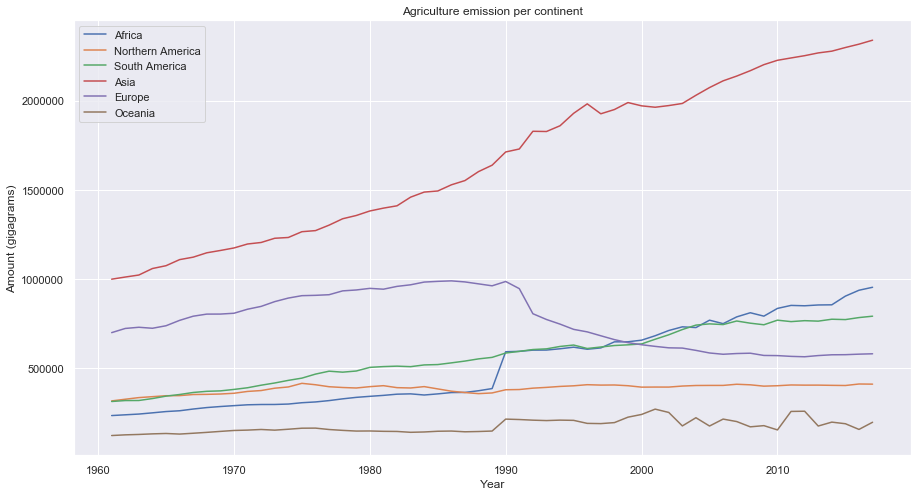

In [146]:
fig = plt.figure(figsize = (15,8))

for area in emission_data.Area.unique():
    plt.plot(emission_data[emission_data['Area'] == area].Year.values, 
             emission_data[emission_data['Area'] == area].Value.values)
    
plt.legend(emission_data.Area.unique())
plt.title('Agriculture emission per continent')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')
plt.show()

#### Plot
The data does not have any extreme outliers and without any particular knowledge in agriculture emissions, the data seems to make sense. We have a few jumps in the data that we will examine later.

#### Emission data number 2

We also have another emissions file with some categories to easier be able to determine differences in emission between crops and livestock production. This data contains emission data for each continent. The dataset can be found here http://www.fao.org/faostat/en/#data/EI.

In [148]:
categorized_emission_data = pd.read_csv('raw_data/Emission_data.csv', sep = ',', encoding = 'latin-1')
explain_df(categorized_emission_data)

The data contain(s) the following: 
    area(s)    : ['Africa', 'Northern America', 'South America', 'Asia', 'Europe', 'Oceania']
    years      : 1961 - 2016
    item(s)    : ['Cereals excluding rice', 'Rice, paddy', 'Meat, cattle', 'Milk, whole fresh cow', 'Meat, goat', 'Milk, whole fresh goat', 'Meat, buffalo', 'Milk, whole fresh buffalo', 'Meat, sheep', 'Milk, whole fresh sheep', 'Milk, whole fresh camel', 'Meat, chicken', 'Eggs, hen, in shell', 'Meat, pig']
    elements(s): ['Emissions (CO2eq)', 'Production']
    unit(s)    : ['gigagrams', 'tonnes']


This dataset contains data about the CO2 emissions coming from various areas (_items_) such as _rice_, _meat, sheep_ etc. Some of the data has information about production of each item which is not out of interest as we are interested in emissions. We will therefore remove rows with these values.

In [149]:
# Keep only emission data
categorized_emission_data = categorized_emission_data[categorized_emission_data.Element == 'Emissions (CO2eq)']

explain_df(categorized_emission_data)
# Is any information missing?
print("Missing information in categorized dataset:\n", categorized_emission_data.isna().sum())
categorized_emission_data.head(3)

The data contain(s) the following: 
    area(s)    : ['Africa', 'Northern America', 'South America', 'Asia', 'Europe', 'Oceania']
    years      : 1961 - 2016
    item(s)    : ['Cereals excluding rice', 'Rice, paddy', 'Meat, cattle', 'Milk, whole fresh cow', 'Meat, goat', 'Milk, whole fresh goat', 'Meat, buffalo', 'Milk, whole fresh buffalo', 'Meat, sheep', 'Milk, whole fresh sheep', 'Milk, whole fresh camel', 'Meat, chicken', 'Eggs, hen, in shell', 'Meat, pig']
    elements(s): ['Emissions (CO2eq)']
    unit(s)    : ['gigagrams']
Missing information in categorized dataset:
 Domain Code         0
Domain              0
Area Code           0
Area                0
Element Code        0
Element             0
Item Code           0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
dtype: int64


,Domain Code,Domain,Area Code,Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,EI,Emissions intensities,5100,Africa,7231,Emissions (CO2eq),1718,Cereals excluding rice,1961,1961,gigagrams,6404.6437,A,"Aggregate, may include official, semi-official..."
1,EI,Emissions intensities,5100,Africa,7231,Emissions (CO2eq),1718,Cereals excluding rice,1962,1962,gigagrams,6841.1636,A,"Aggregate, may include official, semi-official..."
2,EI,Emissions intensities,5100,Africa,7231,Emissions (CO2eq),1718,Cereals excluding rice,1963,1963,gigagrams,7246.6931,A,"Aggregate, may include official, semi-official..."


We can see that this dataset is similar to the previous one apart from the _item_ column which contains multiple values, this is what we wanted. Futhermore we have no missing values. Let's save this file.

**For now we will stick to the first dataset discussed in this notebook section since we are more interested in the total agriculture emissions.**

Let's plot the _Agriculture, total_ emissions from the dataset 1. Let's also make use of the population data so we can normalize the data on the population of a given continent or the world.

In [150]:
# Get population data
population = pd.read_csv('./data/csv/pop_continents.csv')

area_year_population = population.groupby(['Area', 'Year']).agg({'Value':'sum','Unit':'first'}).reset_index()
world_year_population = area_year_population.groupby('Year').agg({'Value':'sum'}).reset_index()

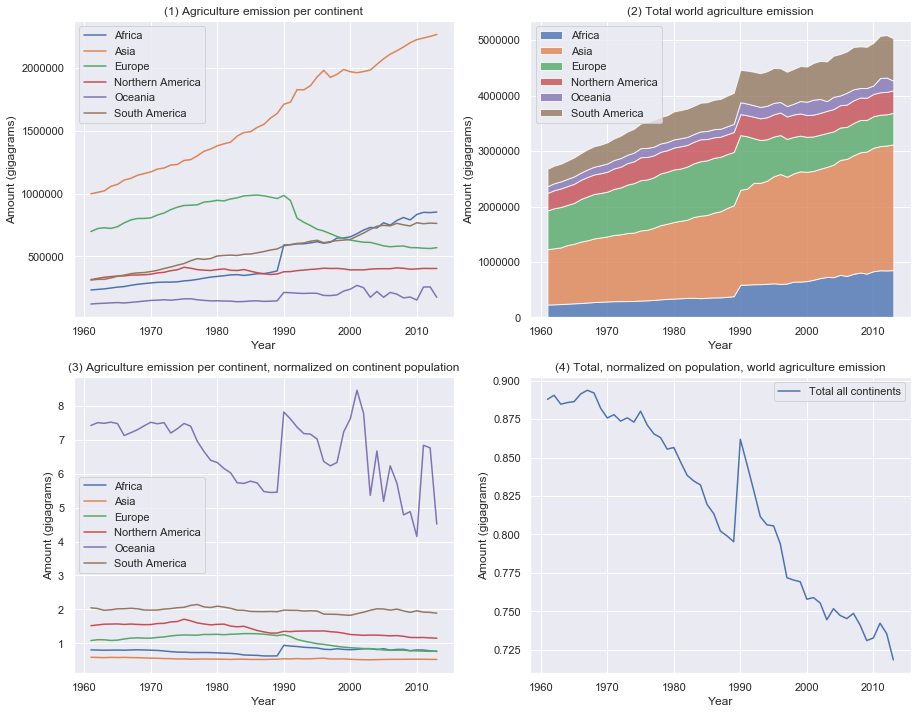

In [151]:
import warnings
warnings.filterwarnings('ignore')

area_year_emission = emission_data.groupby(['Area', 'Year']).agg({'Value':'sum','Unit':'first'}).reset_index()
area_year_emission = area_year_emission[(area_year_emission['Year'] <= 2013)]

x = area_year_emission.Year.unique()
plot_y_emi = []
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:pink']  
fig = plt.figure(figsize = (15,12))

areas = area_year_emission.Area.unique()

for area in areas:
    plt.subplot(2,2,3)
    plt.plot(area_year_emission[area_year_emission['Area'] == area].Year.values, 
             area_year_emission[area_year_emission['Area'] == area].Value.values/
             area_year_population[area_year_population['Area'] == area].Value.values)
   
    plt.subplot(2,2,1)
    plt.plot(area_year_emission[area_year_emission['Area'] == area].Year.values, 
             area_year_emission[area_year_emission['Area'] == area].Value.values)
    
    plot_y_emi.append(area_year_emission[area_year_emission['Area'] == area].Value.values.tolist())

plt.subplot(2,2,1)
plt.legend(areas)
plt.title('(1) Agriculture emission per continent')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')

plt.subplot(2,2,3)
plt.legend(areas)
plt.title('(3) Agriculture emission per continent, normalized on continent population')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')

# Global yearly emission
total_year_emission = area_year_emission.groupby('Year').agg({'Value':'sum'}).reset_index()
total_year_emission = total_year_emission[total_year_emission['Year'] <= 2013]

plt.subplot(2,2,2)
plt.stackplot(x, np.vstack(plot_y_emi), labels=area_year_emission.Area.unique(), alpha=0.8)
plt.legend(loc='upper left')
plt.title('(2) Total world agriculture emission')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')

plt.subplot(2,2,4)
plt.plot(total_year_emission['Year'].values,
        total_year_emission['Value'].values/world_year_population['Value'].values)
plt.legend(['Total all continents'])
plt.title('(4) Total, normalized on population, world agriculture emission')
plt.xlabel('Year')
plt.ylabel('Amount (gigagrams)')

plt.show()

##### Emission area plot 
There are a few questions that arise when observing the plots above:
- We can observe a big increase in emission around year 1990 which seems slightly weird.
- In the normalized continent emissions _Oceania_ has a much greater and volatile normalized emission compared to the other continents. The relatively higher normalized emission by _Oceania_ could be reasonable given that they have a lot of livestock production, however the sudden jumps in value from year to year seem off.

Let's try and find an answer to these obeservations.
The reason that the emission jumps in 1990 is most likely because of _New estimates of CO2 forest emissions and removals: 1990–2015._ Which is stated [at faostat](http://www.fao.org/faostat/en/#data/GT/metadata), where the data comes from, in point number 10.

Now, when it comes to the weird behaviour in _Oceania_'s emissions when should look at the data we have acquired regarding the crop and livestock production aswell as the population that _Oceania_ has in order to explain the weirdness. 
 

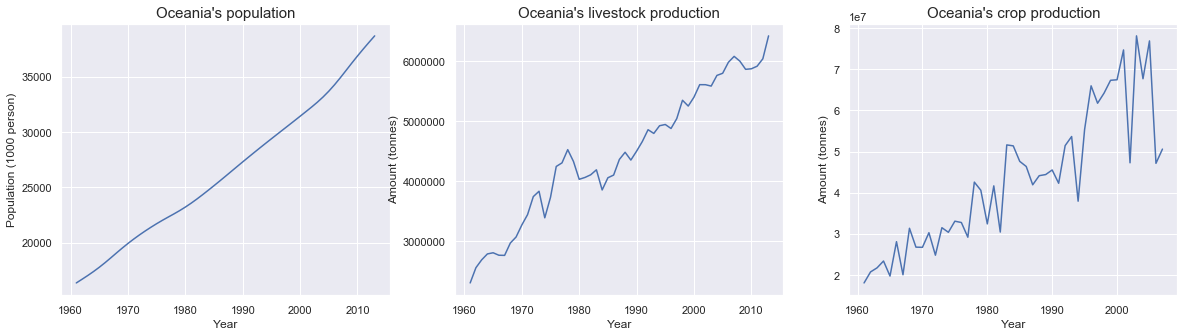

In [152]:
fig = plt.figure(figsize=(20,5))

# Oceania's population
plt.subplot(1,3,1)
plt.plot(area_year_population.Year.unique(), area_year_population[area_year_population.Area == 'Oceania'].Value.values)
plt.title('Oceania\'s population', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Population (1000 person)')

# Oceania's livestock production
plt.subplot(1,3,2)
meat_production_continents = pd.read_csv('data/csv/meat_continents.csv')
meat_production_oceania = meat_production_continents[(meat_production_continents.Area == 'Oceania') \
                                                     & (meat_production_continents.Item == 'Meat, Total')]
plt.plot(meat_production_oceania.Year.unique(), meat_production_oceania.Value.values)
plt.title('Oceania\'s livestock production', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Amount (tonnes)')

# Oceania's crops production
crop_production_continents = pd.read_pickle('data/pickles/crops_continents.pkl')
crop_production_oceania = crop_production_continents[(crop_production_continents.Area == 'Oceania')]\
                                                    .groupby('Year').agg({'Value':'sum'}).reset_index()
plt.subplot(1,3,3)
plt.plot(crop_production_oceania.Year.unique(), crop_production_oceania.Value.values)
plt.title('Oceania\'s crop production', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Amount (tonnes)')

plt.show()

We can see that there is nothing that seems to be weird with the _Oceania_'s population data, however the livestock and especially the crop production is volatile. This corresponds with the diffrences that we can observe in the agriculture emission caused by _Oceania_. Since _Oceania_ is the continent which produces the least amount of CO2 from agriculture compared to all other continents it is more likely to be volatile. For example, if the weather is bad for agriculture, it is more likely that the total amount will be affected compared to a bigger continent that is not as concentrated around a specific area.

#### Summarize

The data looks good and we are ready to move further with our analysis and use this data to answer the questions.

#### Correlation

In [153]:
# Correlations
corr = np.corrcoef(x = total_year_emission.Value.values, y = world_year_population.Value.values)[0,1]
print(f'Correlation between agriculture emission and population is {round(corr,2)}')

Correlation between agriculture emission and population is 0.99


#### Example use of second emissions dataset

In [154]:
# Emission data for sheep production for every continent and year
sheep_prod = categorized_emission_data[categorized_emission_data.Item.str.contains('sheep')]

sheep_data = sheep_prod.groupby(['Area','Element','Year','Unit']).agg({'Value':'sum'})
sheep_data['Item'] = 'Sheep'

In [155]:
sheep_data.reset_index()

,Area,Element,Year,Unit,Value,Item
0,Africa,Emissions (CO2eq),1961,gigagrams,26107.8934,Sheep
1,Africa,Emissions (CO2eq),1962,gigagrams,25742.8884,Sheep
2,Africa,Emissions (CO2eq),1963,gigagrams,25928.7068,Sheep
3,Africa,Emissions (CO2eq),1964,gigagrams,26531.4870,Sheep
4,Africa,Emissions (CO2eq),1965,gigagrams,27693.8435,Sheep
...,...,...,...,...,...,...
331,South America,Emissions (CO2eq),2012,gigagrams,13038.5218,Sheep
332,South America,Emissions (CO2eq),2013,gigagrams,13089.1212,Sheep
333,South America,Emissions (CO2eq),2014,gigagrams,12595.7720,Sheep
334,South America,Emissions (CO2eq),2015,gigagrams,12690.6373,Sheep


<a id=plan></a>
## Plan for Milestone 3

## Internal Milestones until Project Milestone 3 

In the ReadMe we have written how we will answer all the research questions, and we will therefore not go in detail of that here.  
This is to be considered an overall plan.

1 - Answer research Questions 1 & 2 (29th November)

2 - Answer research Questions 3 & 4. (6th December)
- Decide on either report or data story.

3 - Finish visuals and make a draft of report/data story (13th December)

4 - Final Deadline (20th December)
- Make sure the report/data story is consistent, and includes all the important information.
- Make sure the final notebook (extending on Milestone 2) is comprehensive and includes all mathematical calculations.
- Update readme with contributions of team members (including who works on the final presentation)

5 - Presentations (18th January)
- Finish poster for presentation
- Decide on who talks
- Prepare a 3 min presentation